In [1]:
# Import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import cv2
import os
import shutil
import pickle

# Import necessary functions

from keras.preprocessing import image
from sklearn.preprocessing import normalize
from skimage.io import imshow
from skimage.feature import local_binary_pattern, hog
from skimage import exposure
from scipy.stats import skew
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, euclidean

%matplotlib inline

## Helper functions

In [2]:
# Slice 64 x 64 image into 64 vectors of 8 x 8
# Helper Function

def slice_channel(channel):
    
    slices = []
    r = 0
    while r < channel.shape[0]:
        c = 0
        while c < channel.shape[1]:
            channel_slice = channel[r:r + 8, c:c + 8]
            slices.append(channel_slice)
            c = c + 8
        r = r + 8
        
    return slices

In [3]:
# This function calculates the mean of the 8X8 matrix provided as slices
def calculate_first_moment(channel):
    
    return np.mean(channel)

# This function calculates the standard deviation of the 8X8 matrix provided as slices
def calculate_second_moment(channel):
    
    return np.std(channel)


# This function calculates the skewness of the 8X8 matrix provided as slices
def calculate_third_moment(channel):
    
    # Flatten the array, and calculate the skewness
    return abs(skew(np.ndarray.flatten(channel), 0))

In [4]:
# This function takes a sliced image as input and returns color moments of shape 8 x 8 x 3

def calculate_CM(img):
    
    sliced_image = slice_channel(img)
    color_m = []
    #iterating each 8X8 matrix 64 times for each image
    for i in sliced_image:
        color_temp =[]
        #append color moments to a temporary array
        color_temp.append(calculate_first_moment(i))
        color_temp.append(calculate_second_moment(i))
        color_temp.append(calculate_third_moment(i))
        #append temporary array to final color moments of all images
        color_m.append(color_temp)
        
    return np.array(color_m).reshape(8,8,3)

In [5]:
# This function extracts local binary patterns for images with 8 neighbors

def calculate_LBP(img):
    
    lbp_features=[]
    lbp = local_binary_pattern(img, 8, 1, 'ror')
    hist, edges = np.histogram(lbp, bins = 256, range = (0.0, 255.0))
    hist = hist.astype("float")
    hist = hist/(hist.sum() + 1e-7)
    lbp_features.append(hist.tolist())
    
    return np.array(lbp_features).reshape(256)

In [6]:
# This function calculates HOG for each image

def calculate_HOG(img):
    
    hog_features=[]
    fd, hog_img = hog(img, orientations=9, pixels_per_cell=(8, 8), visualize=True, cells_per_block=(2, 2), block_norm='L2-Hys')
    hog_features.append(fd)
    
    return fd

In [7]:
# This Function reduces dimensions using SVD

def do_svd(data_mat, k):
    
    u, s, vt = np.linalg.svd(data_mat, full_matrices=True)
    u = u[:, :k]
    vt = vt[:k, :]
    #here returning the u that is latent semantic (n,k) and s which is n eigen values
    return [u, vt]

In [8]:
"""def do_svd(data_mat,k): 
    
    DDTranspose=np.matmul(data_mat,data_mat.T)
    DTransposeD=np.matmul(data_mat.T,data_mat)
    
    eigen_values_DDT , eigen_vectors_DDT = np.linalg.eigh(DDTranspose)
    eigen_values_DTD , eigen_vectors_DTD = np.linalg.eigh(DTransposeD)
    
    #sort the eigenvalues_DDT in descending order
    sorted_index_DDT = np.argsort(eigen_values_DDT)[::-1]
    sorted_eigenvalue_DDT = eigen_values_DDT[sorted_index_DDT]
    #similarly sort the eigenvectors 
    sorted_eigenvectors_DDT = eigen_vectors_DDT[:,sorted_index_DDT]
    eigenvector_subset_DDT = sorted_eigenvectors_DDT[:,0:k]
    
    #sort the eigenvalues_DTD in descending order
    sorted_index_DTD = np.argsort(eigen_values_DTD)[::-1]
    sorted_eigenvalue_DTD = eigen_values_DTD[sorted_index_DTD]
    #similarly sort the eigenvectors 
    sorted_eigenvectors_DTD = eigen_vectors_DTD[:,sorted_index_DTD]
    eigenvector_subset_DTD = sorted_eigenvectors_DTD[:,0:k]
    LS = np.identity(k)
    for i in range(k):
        LS[i][i] = sorted_eigenvalue_DTD[i]
    
    return [eigenvector_subset_DDT, np.sqrt(LS)]"""

'def do_svd(data_mat,k): \n    \n    DDTranspose=np.matmul(data_mat,data_mat.T)\n    DTransposeD=np.matmul(data_mat.T,data_mat)\n    \n    eigen_values_DDT , eigen_vectors_DDT = np.linalg.eigh(DDTranspose)\n    eigen_values_DTD , eigen_vectors_DTD = np.linalg.eigh(DTransposeD)\n    \n    #sort the eigenvalues_DDT in descending order\n    sorted_index_DDT = np.argsort(eigen_values_DDT)[::-1]\n    sorted_eigenvalue_DDT = eigen_values_DDT[sorted_index_DDT]\n    #similarly sort the eigenvectors \n    sorted_eigenvectors_DDT = eigen_vectors_DDT[:,sorted_index_DDT]\n    eigenvector_subset_DDT = sorted_eigenvectors_DDT[:,0:k]\n    \n    #sort the eigenvalues_DTD in descending order\n    sorted_index_DTD = np.argsort(eigen_values_DTD)[::-1]\n    sorted_eigenvalue_DTD = eigen_values_DTD[sorted_index_DTD]\n    #similarly sort the eigenvectors \n    sorted_eigenvectors_DTD = eigen_vectors_DTD[:,sorted_index_DTD]\n    eigenvector_subset_DTD = sorted_eigenvectors_DTD[:,0:k]\n    LS = np.identity(k)

In [9]:
# This Function reduces dimensions using PCA

def do_pca(data_mat,k): 
    
    X_meaned = data_mat - np.mean(data_mat , axis = 0)
    cov_mat = np.cov(X_meaned , rowvar = False)
    eigen_values , eigen_vectors = np.linalg.eig(cov_mat)
    #sort the eigenvalues in descending order
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    #similarly sort the eigenvectors 
    sorted_eigenvectors = eigen_vectors[:,sorted_index]
    eigenvector_subset = sorted_eigenvectors[:,0:k]
    #transformed data into lower dimensions
    X_reduced = np.dot(eigenvector_subset.transpose(),X_meaned.transpose()).transpose()
    #here returning the eigenvector_subset that is latent semantic (n,k) and sorted_eigenvalue which is n eigen values 
    
    return [X_reduced,eigenvector_subset.T]

In [10]:
# This Function reduces dimensions using LDA

def do_lda(data_mat, k):
    
    lda = LatentDirichletAllocation(n_components=k, batch_size = 10)
    lda_f = lda.fit(data_mat)
    lda_weights = lda_f.transform(data_mat)
    
    return [lda_weights, lda_f.components_] # U, Vt

In [11]:
# This Function reduces dimensions using k-Means

def do_kmeans(data_mat, k):
    
    kmeans = KMeans(n_clusters=k).fit(np.array(data_mat).T)
    centroids = kmeans.cluster_centers_

    return [np.array(centroids).T]

In [12]:
# This Function returns dimenionally reduced data

def reduce_dims(data_mat, k, DR):
    if DR == 'PCA':
        return do_pca(data_mat, k)
    elif DR == 'SVD':
        return do_svd(data_mat, k)
    elif DR == 'LDA':
        return do_lda(data_mat, k)
    elif DR == 'kmeans':
        return do_kmeans(data_mat, k)
    else:
        print("Please select a valid method")

In [13]:
#This function saves and retrieves objects

def save_obj(obj, fname):
    file_df = open(fname, 'wb') 
    pickle.dump(obj, file_df)

def retrieve_obj(fname):
    file_df = open(fname, 'rb') 
    df = pickle.load(file_df)
    return df

In [14]:
# This function extracts features from images based on model provided

def extract_feature(input_img, model):
    
    if model == 'CM':
        return calculate_CM(input_img).flatten() 
    elif model == 'ELBP':
        return calculate_LBP(input_img)
    elif model == 'HOG':
        return calculate_HOG(input_img).flatten()
    else:
        print('Please enter a valid model')

In [15]:
def db_feature_extraction(FM):
    
    #retrieving all images in database
    os.chdir(obj_path)
    db=retrieve_obj('image_data_all_u.obj')
    #constructing new dict with keys name of images and values as its extracted features
    db_feature=dict.fromkeys(list(db.keys()))
    for key,value in db.items():
        db_feature[key]=extract_feature(value,FM)
        
    return db_feature

In [16]:
def LS_extract(ans):
    LS={}
    for i in range(len(ans)):
        temp = ans[i]
        dic={}
        for j in range(len(temp)):
            dic[j] = temp[j]

        sorted_values = list(reversed(sorted(dic.values()))) # Sort the values
        sorted_dict = {}

        for j in range(len(sorted_values)):
            for k in dic.keys():
                if dic[k] == sorted_values[j]:
                    sorted_dict[k] = dic[k]
                    break
        LS[i] = sorted_dict
    return LS

In [17]:
def create_LS(nm, LS_dic):
    latent_sem = open(nm, "w+")
    for i in range(len(LS_dic.keys())):
        latent_sem.write('\nLS:' + str(i+1) + '\n')
        latent_sem.write(str(LS_dic[i]) + '\n')
    latent_sem.close() 
    print('\nLatent Semantic file created : ',nm)

In [76]:
def compute_sub_sub(FM):
    
    os.chdir(obj_path)
    ss_cm = retrieve_obj('sub_sub_'+FM+'.obj')
    ss=[]
    for i in ss_cm.values():
        b=[]
        for j in ss_cm.values():
            b.append(abs(sum(np.array(i) - np.array(j))))
        ss.append(b)

    sub_sub = np.array(ss)

    for index, i in enumerate(sub_sub):
        min_array = sorted(i)[1:n]

        for index2, _ in enumerate(i):
            if _ not in min_array:
                sub_sub[index, index2] = 0

    return sub_sub


In [18]:
def feature_extract_t1(FM, X):
    
    os.chdir(obj_path)
    data = retrieve_obj('image_data_all_u.obj')
    
    dic={}
    for i in data.keys():
        _, X_t, Y, Z = i.split("-")
        Z = Z.split(".")[0]
        
        if X_t == X:
            if Y in dic.keys():
                dic[Y].append(data[i])
            else:
                dic[Y] = [data[i]]
          
    fin = {}
    for j in dic.keys():
        temp=[]
        for kj in dic[j]:
            if FM == "CM" :
                temp.append(calculate_CM(kj).flatten())
            elif FM == 'ELBP':
                temp.append(calculate_LBP(kj))
            elif FM == 'HOG':
                temp.append(calculate_HOG(kj).flatten())
                
        #print(np.array(temp).shape)
        fin[j] = np.array(temp).mean(axis=0)
    return fin

In [19]:
def feature_extract_t2(FM, Y):
    
    os.chdir(obj_path)
    data = retrieve_obj('image_data_all_u.obj')

    dic={}    
    for i in data.keys():
        _, X, Y_t, Z = i.split("-")
        Z = Z.split(".")[0]

        if Y_t == Y:
            if X in dic.keys():
                dic[X].append(data[i])
            else:
                dic[X] = [data[i]]
          
    fin = {}
    for j in dic.keys():
        temp=[]
        for kj in dic[j]:
            if FM == "CM" :
                temp.append(calculate_CM(kj).flatten())
            elif FM == 'ELBP':
                temp.append(calculate_LBP(kj))
            elif FM == 'HOG':
                temp.append(calculate_HOG(kj).flatten())
        fin[j] = np.array(temp).mean(axis=0)
    
    return fin

In [20]:
## This needs to be executed only once to calculate type-type similarity matrix for each color model

"""def feature_extract_t3(FM):

    os.chdir(obj_path)
    data = retrieve_obj('image_data_all.obj')

    tt_arr={}

    for im_k, im_v in data.items():      

        _, X, Y, Z = im_k.split("-")
        Z = Z.split(".")[0]

        if X in tt_arr.keys():
            if int(Z) != 10:
                if FM == 'CM':
                    tt_arr[X]+=list(calculate_CM(im_v).flatten())
                elif FM == 'ELBP':
                    tt_arr[X]+=list(calculate_LBP(im_v))
                elif FM == 'HOG':
                    tt_arr[X]+=list(calculate_HOG(im_v).flatten())
        else:
            if FM == 'CM':
                tt_arr[X]=list(calculate_CM(im_v).flatten())
            elif FM == 'ELBP':
                tt_arr[X]=list(calculate_LBP(im_v))
            elif FM == 'HOG':
                tt_arr[X]=list(calculate_HOG(im_v).flatten())
    return tt_arr

ans = feature_extract_t3('CM')

save_obj(ans, 'type_type_CM.obj')"""

'def feature_extract_t3(FM):\n\n    os.chdir(obj_path)\n    data = retrieve_obj(\'image_data_all.obj\')\n\n    tt_arr={}\n\n    for im_k, im_v in data.items():      \n\n        _, X, Y, Z = im_k.split("-")\n        Z = Z.split(".")[0]\n\n        if X in tt_arr.keys():\n            if int(Z) != 10:\n                if FM == \'CM\':\n                    tt_arr[X]+=list(calculate_CM(im_v).flatten())\n                elif FM == \'ELBP\':\n                    tt_arr[X]+=list(calculate_LBP(im_v))\n                elif FM == \'HOG\':\n                    tt_arr[X]+=list(calculate_HOG(im_v).flatten())\n        else:\n            if FM == \'CM\':\n                tt_arr[X]=list(calculate_CM(im_v).flatten())\n            elif FM == \'ELBP\':\n                tt_arr[X]=list(calculate_LBP(im_v))\n            elif FM == \'HOG\':\n                tt_arr[X]=list(calculate_HOG(im_v).flatten())\n    return tt_arr\n\nans = feature_extract_t3(\'CM\')\n\nsave_obj(ans, \'type_type_CM.obj\')'

In [21]:
## This needs to be executed only once to calculate subject-subject similarity matrix for each color model

"""
def feature_extract_t4(FM):

    os.chdir(obj_path)
    data = retrieve_obj('image_data_all.obj')

    ss_arr={}

    for im_k, im_v in data.items():      

        _, X, Y, Z = im_k.split("-")
        Z = Z.split(".")[0]

        if Y in ss_arr.keys():
            if int(Z) != 10:
                if FM == 'CM':
                    ss_arr[Y]+=list(calculate_CM(im_v).flatten())
                elif FM == 'ELBP':
                    ss_arr[Y]+=list(calculate_LBP(im_v))
                elif FM == 'HOG':
                    ss_arr[Y]+=list(calculate_HOG(im_v).flatten())
        else:
            if FM == 'CM':
                ss_arr[Y]=list(calculate_CM(im_v).flatten())
            elif FM == 'ELBP':
                ss_arr[Y]=list(calculate_LBP(im_v))
            elif FM == 'HOG':
                ss_arr[Y]=list(calculate_HOG(im_v).flatten())
    return ss_arr

ans = feature_extract_t4('HOG')

#save_obj(ans, 'sub_sub_HOG.obj')"""

'\ndef feature_extract_t4(FM):\n\n    os.chdir(obj_path)\n    data = retrieve_obj(\'image_data_all.obj\')\n\n    ss_arr={}\n\n    for im_k, im_v in data.items():      \n\n        _, X, Y, Z = im_k.split("-")\n        Z = Z.split(".")[0]\n\n        if Y in ss_arr.keys():\n            if int(Z) != 10:\n                if FM == \'CM\':\n                    ss_arr[Y]+=list(calculate_CM(im_v).flatten())\n                elif FM == \'ELBP\':\n                    ss_arr[Y]+=list(calculate_LBP(im_v))\n                elif FM == \'HOG\':\n                    ss_arr[Y]+=list(calculate_HOG(im_v).flatten())\n        else:\n            if FM == \'CM\':\n                ss_arr[Y]=list(calculate_CM(im_v).flatten())\n            elif FM == \'ELBP\':\n                ss_arr[Y]=list(calculate_LBP(im_v))\n            elif FM == \'HOG\':\n                ss_arr[Y]=list(calculate_HOG(im_v).flatten())\n    return ss_arr\n\nans = feature_extract_t4(\'HOG\')\n\n#save_obj(ans, \'sub_sub_HOG.obj\')'

In [22]:
def feature_extract_t6(FM, Y):
    
    os.chdir(obj_path)
    data = retrieve_obj('image_data_all_u.obj')

    dic={}    
    for i in data.keys():
        _, X, Y_t, Z = i.split("-")
        Z = Z.split(".")[0]

        if Y_t == Y:
            if X in dic.keys():
                dic[X].append(data[i])
            else:
                dic[X] = [data[i]]
          
    fin = {}
    for j in dic.keys():
        temp=[]
        for kj in dic[j]:
            if FM == "CM" :
                temp.append(calculate_CM(kj).flatten())
            elif FM == 'ELBP':
                temp.append(calculate_LBP(kj))
            elif FM == 'HOG':
                temp.append(calculate_HOG(kj).flatten())
        fin[j] = np.array(temp).mean(axis=0)
    
    return fin

In [23]:
def feature_extract_t7(FM, X):
    
    os.chdir(obj_path)
    data = retrieve_obj('image_data_all_u.obj')
    
    dic={}
    for i in data.keys():
        _, X_t, Y, Z = i.split("-")
        Z = Z.split(".")[0]
        
        if X_t == X:
            if Y in dic.keys():
                dic[Y].append(data[i])
            else:
                dic[Y] = [data[i]]
          
    fin = {}
    for j in dic.keys():
        temp=[]
        for kj in dic[j]:
            if FM == "CM" :
                temp.append(calculate_CM(kj).flatten())
            elif FM == 'ELBP':
                temp.append(calculate_LBP(kj))
            elif FM == 'HOG':
                temp.append(calculate_HOG(kj).flatten())
        fin[j] = np.array(temp).mean(axis=0)
    return fin

In [24]:
"""# This code creates an object which needs to be created only once

obj_path = 'C:\\Users\\hp\\OneDrive\\Desktop\\saved_obj\\'
img_path = 'C:\\Users\\hp\\OneDrive\\Desktop\\all\\'

os.chdir(img_path)
img_file = os.listdir()

data = {}
for im in img_file:  
    
    if not(im.endswith(".png")):
        img_file.remove(im)
        continue
        
    img = image.load_img(im, target_size =(64, 64), color_mode='grayscale' )
    img = image.img_to_array(img).reshape((64,64))
    img = img/255.0
    
    _, X, Y_t, Z = im.split("-")
    Z = Z.split(".")[0]
    if Z != '10':
        data[im] = img
        

os.chdir(obj_path)
save_obj(data, 'image_data_all_u.obj')"""

'# This code creates an object which needs to be created only once\n\nobj_path = \'C:\\Users\\hp\\OneDrive\\Desktop\\saved_obj\\\'\nimg_path = \'C:\\Users\\hp\\OneDrive\\Desktop\\all\\\'\n\nos.chdir(img_path)\nimg_file = os.listdir()\n\ndata = {}\nfor im in img_file:  \n    \n    if not(im.endswith(".png")):\n        img_file.remove(im)\n        continue\n        \n    img = image.load_img(im, target_size =(64, 64), color_mode=\'grayscale\' )\n    img = image.img_to_array(img).reshape((64,64))\n    img = img/255.0\n    \n    _, X, Y_t, Z = im.split("-")\n    Z = Z.split(".")[0]\n    if Z != \'10\':\n        data[im] = img\n        \n\nos.chdir(obj_path)\nsave_obj(data, \'image_data_all_u.obj\')'

In [25]:
obj_path = 'C:\\Users\\hp\\OneDrive\\Desktop\\saved_obj\\'
img_path = 'C:\\Users\\hp\\OneDrive\\Desktop\\all\\'

### Original Data Distribution

In [26]:
obj_path = 'C:\\Users\\hp\\OneDrive\\Desktop\\saved_obj\\'

os.chdir(obj_path)
data = retrieve_obj('image_data_all.obj')
    
dic={}
for i in data:
    _, X, Y_t, Z = i.split("-")
    Z = Z.split(".")[0]
    if X in dic.keys():
        dic[X]+=1
    else:
        dic[X]=1
    
print("Distribution of types:\n",dic)

print("\nTotal Images:", sum(dic.values()))

Distribution of types:
 {'cc': 399, 'con': 399, 'emboss': 398, 'jitter': 399, 'neg': 399, 'noise01': 399, 'noise02': 399, 'original': 399, 'poster': 399, 'rot': 399, 'smooth': 399, 'stipple': 399}

Total Images: 4787


### New Data distribution

In [27]:
obj_path = 'C:\\Users\\hp\\OneDrive\\Desktop\\saved_obj\\'

os.chdir(obj_path)
data = retrieve_obj('image_data_all_u.obj')
    
dic={}
for i in data:
    _, X, Y_t, Z = i.split("-")
    if X in dic.keys():
        dic[X]+=1
    else:
        dic[X]=1
        
print("Distribution of types:\n",dic)
print("\nTotal Images:", sum(dic.values()))

Distribution of types:
 {'cc': 360, 'con': 360, 'emboss': 360, 'jitter': 360, 'neg': 360, 'noise01': 360, 'noise02': 360, 'original': 360, 'poster': 360, 'rot': 360, 'smooth': 360, 'stipple': 360}

Total Images: 4320


# Task 1: 

Implement a program which 

(a) given one of the three feature models, 

(b) a user specified value of X, 

(c) a user specified value of k, 

(d) one of the four dimensionality reduction techniques (PCA, SVD, LDA, k-means) chosen by the user, 

reports the top-k latent semantics extracted using images of this type. Each latent semantic should be presented in
the form of a list of subject-weight pairs, ordered in decreasing order of weights. Store the latent semantics in a properly
labeled output file.

In [28]:
def task1(FM, X, k, DR):
    arr = feature_extract_t1(FM, X)
    ans = reduce_dims(np.array(list(arr.values())), k, DR)   
    LS_dic = LS_extract(ans[0].T)
            
    os.chdir(obj_path)
    nm = 'T1-LS' + '-' + FM + '-' + X + '-' + str(k) + '-' + DR + '.txt'
    create_LS(nm, LS_dic)
    
    return ans

In [32]:
FM = input("Enter a feature model - CM, ELBP, HOG :")
X = input("Enter a value of X:")
k = int(input("Enter a value of k:"))
DR = input("Enter a dimentionality reduction technique - PCA, LDA, SVD, kmeans:")

ans = task1(FM, X, k, DR)

Enter a feature model - CM, ELBP, HOG :CM
Enter a value of X:cc
Enter a value of k:25
Enter a dimentionality reduction technique - PCA, LDA, SVD, kmeans:kmeans

Latent Semantic file created :  T1-LS-CM-cc-25-kmeans.txt


In [34]:
print(ans[0].shape)

(40, 25)


# Task 2: 
Implement a program which 

(a) given one of the three feature models, 

(b) a user specified value of Y , 

(c) a user specified value of k, 

(d) one of the three dimensionality reduction techniques (PCA, SVD, LDA,k-means) chosen by the user, 

reports the top-k latent semantics extracted using images of this subject. Each latent semantic should be presented
in the form of a list of type-weight pairs, ordered in decreasing order of weights. Store the latent semantics in a properly
labeled output file.

In [35]:
def task2(FM, Y, k, DR):
    arr = feature_extract_t2(FM, Y)
    ans = reduce_dims(np.array(list(arr.values())), k, DR)    
    LS_dic = LS_extract(ans[0].T)
    
    os.chdir(obj_path)
    nm = 'T2-LS' + '-' + FM + '-' + Y + '-' + str(k) + '-' + DR + '.txt'
    create_LS(nm, LS_dic)
    return ans

In [42]:
FM = input("Enter a feature model - CM, ELBP, HOG :")
Y = input("Enter a value of Y:")
k = int(input("Enter a value of k:"))
DR = input("Enter a dimentionality reduction technique - PCA, LDA, SVD, k-means:")

ans = task2(FM, Y, k, DR)

Enter a feature model - CM, ELBP, HOG :CM
Enter a value of Y:35
Enter a value of k:10
Enter a dimentionality reduction technique - PCA, LDA, SVD, k-means:kmeans

Latent Semantic file created :  T2-LS-CM-35-10-kmeans.txt


In [41]:
print(ans[0].shape, ans[1].shape)

(12, 10) (10, 1764)


### Task 3: 
Implement a program which, 

(a) given one of the three feature models and 

(b) a value k,

– creates (and saves) a type-type similarity matrix,

– performs a user selected dimensionality reduction technique (PCA, SVD, LDA,k-means) on this type-type similarity
matrix, and

– reports the top-k latent semantics.

Each latent semantic should be presented in the form of a list of type-weight pairs, ordered in decreasing order of weights.
Store the latent semantics in a properly labeled output file.

In [43]:
def task3(FM, k, DR):
    
    tt_fm = retrieve_obj('type_type_'+FM+'.obj')
    tt=[]
    for i in tt_fm.values():
        b=[]
        for j in tt_fm.values():
            b.append(abs(sum(np.array(i) - np.array(j))))
        tt.append(b)
    
    type_type = np.array(tt)
    ans = reduce_dims(type_type, k, DR)
    ans = np.array(ans, dtype=object)
    
    LS_dic = LS_extract(ans[0].T)
    
    os.chdir(obj_path)
    nm = 'T3-LS' + '-' + FM + '-' + str(k) + '-' + DR + '.txt'
    create_LS(nm, LS_dic)
    
    return type_type, ans

In [47]:
FM = input("Enter a feature model - CM, ELBP, HOG :")
k = int(input("Enter a value of k:"))
DR = input("Enter a dimentionality reduction technique - PCA, LDA, SVD, k-means:")

type_type, top_k_LS = task3(FM, k, DR)

Enter a feature model - CM, ELBP, HOG :CM
Enter a value of k:10
Enter a dimentionality reduction technique - PCA, LDA, SVD, k-means:kmeans

Latent Semantic file created :  T3-LS-CM-10-kmeans.txt


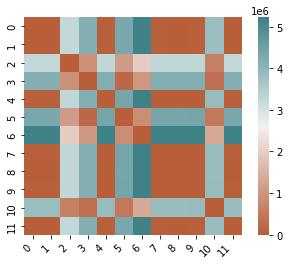

In [48]:
ax = sns.heatmap(
    pd.DataFrame(type_type), 
    #vmin=-100, vmax=100, center=0,
    cmap=sns.diverging_palette(25, 200, n=2000),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### Task 4: 
Implement a program which, (a) given one of the three feature models and (b) a value k,

– creates (and saves) a subject-subject similarity matrix,

– performs a user selected dimensionality reduction technique (PCA, SVD, LDA,k-means) on this subject-subject
similarity matrix, and

– reports the top-k latent semantics.

Each latent semantic should be presented in the form of a list of subject-weight pairs, ordered in decreasing order of
weights. Store the latent semantics in a properly labeled output file.

In [49]:
def task4(FM, k, DR):

    ss_cm = retrieve_obj('sub_sub_'+FM+'.obj')
    ss=[]
    for i in ss_cm.values():
        b=[]
        for j in ss_cm.values():
            b.append(abs(sum(np.array(i) - np.array(j))))
        ss.append(b)

    sub_sub = np.array(ss)
    ans = reduce_dims(sub_sub, k, DR)
    ans = np.array(ans, dtype=object)
    
    LS_dic = LS_extract(ans[0].T)
    
    os.chdir(obj_path)
    nm = 'T4-LS' + '-' + FM + '-' + str(k) + '-' + DR + '.txt'
    create_LS(nm, LS_dic)
    
    return sub_sub, ans

In [53]:
FM = input("Enter a feature model - CM, ELBP, HOG :")
k = int(input("Enter a value of k:"))
DR = input("Enter a dimentionality reduction technique - PCA, LDA, SVD, kmeans:")

sub_sub, top_k_LS = task4(FM, k, DR)

Enter a feature model - CM, ELBP, HOG :CM
Enter a value of k:5
Enter a dimentionality reduction technique - PCA, LDA, SVD, kmeans:kmeans

Latent Semantic file created :  T4-LS-CM-5-kmeans.txt


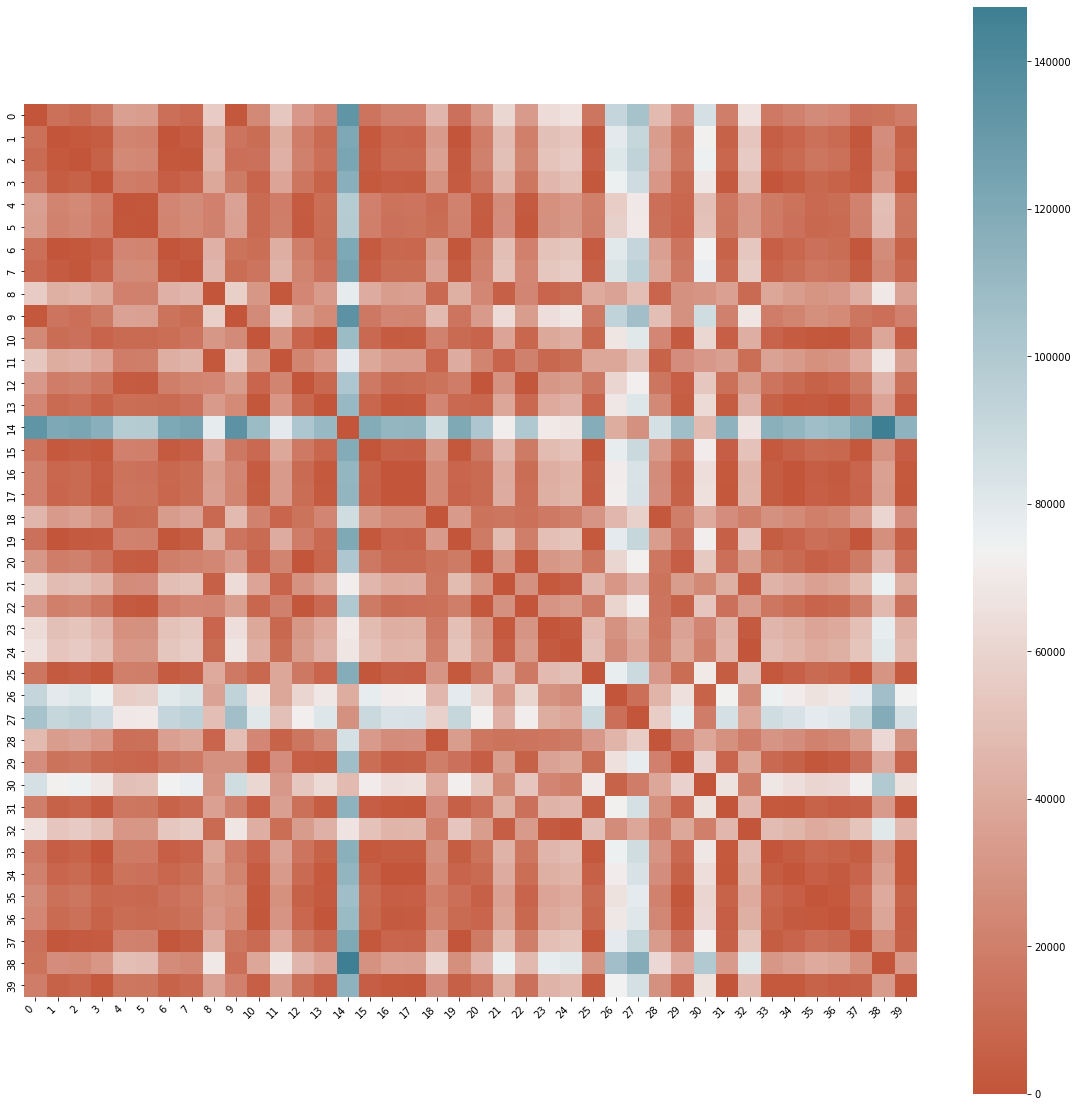

In [54]:
plt.figure(figsize=(20,20))

ax = sns.heatmap(
    pd.DataFrame(sub_sub), 
    #vmin=-1000, vmax=1000, center=0,
    cmap=sns.diverging_palette(20, 220, n=1000),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### Task 5:

Implement a program which, given the filename of a query image which may not be in the database and a latent
semantics file, identifies and visualizes the most similar n images under the selected latent semantics.

In [203]:
def task5(query_image, FM, DR, k, n):
     
    os.chdir(img_path)
    img = image.load_img(img_nm, target_size =(64, 64), color_mode='grayscale' )
    img = image.img_to_array(img).reshape((64,64))
    query_image = img/255.0
    
    query_feature = extract_feature(query_image, FM)
    query_feature=query_feature.reshape(1,-1)
    
    os.chdir(obj_path)
    temp = 'all_data_feature_'+FM+'.obj'
    db_feature=retrieve_obj(temp)
    
    image_names=list(db_feature.keys())
    db_feature_array=np.array(list(db_feature.values()))
    db_feature_array=np.append(db_feature_array, query_feature,axis=0)
    ans=reduce_dims(db_feature_array,k,DR)
    
    LS=ans[0]
    LS_query=LS[-1]
    LS_dist={}
    image_names.append('query_image')
    
    for key, i in zip(image_names, LS):
        LS_dist[key] = euclidean(LS_query, i)
    
    sorted_values = (sorted(LS_dist.values())) # Sort the values
    sorted_dict = {}

    for j in range(len(sorted_values)):
        for k in LS_dist.keys():
            if LS_dist[k] == sorted_values[j]:
                sorted_dict[k] = LS_dist[k]
                break           
    lis=list(sorted_dict.keys())[:n]
    
    return lis

In [204]:
query_image = input("Enter name of input image : ")
FM = input("Enter a feature model - CM, ELBP, HOG :")
k = int(input("Enter a value of k:"))
DR = input("Enter a dimentionality reduction technique - PCA, LDA, SVD, kmeans:")
n = int(input("Enter value of n:"))

#task5(query_image='image-cc-5-3.png', FM='CM', DR='PCA', k=50, n=10)
task5(query_image, FM, DR, k, n)

['image-original-1-1.png',
 'image-poster-1-1.png',
 'image-original-1-3.png',
 'image-original-16-3.png',
 'image-poster-1-3.png',
 'image-original-16-2.png',
 'image-original-1-7.png',
 'image-original-24-2.png',
 'image-poster-16-3.png',
 'image-poster-16-2.png']

### Task 6:

Implement a program which, given the filename of a query image which may not be in the database and a latent
semantics file, associates a type label (X) to the image under the selected latent semantics.

In [86]:
def task6(img_name, FM, k, DR, Y):

    os.chdir(obj_path)
    arr = feature_extract_t6(FM, Y)
    ans = reduce_dims(np.array(list(arr.values())), k, DR)

    os.chdir(img_path)
    img = image.load_img(img_name, target_size =(64, 64), color_mode='grayscale' )
    img = image.img_to_array(img).reshape((64,64))
    img = img/255.0

    feaVec = extract_feature(img, model=FM)
    fv = np.dot(ans[1], feaVec)

    dis={}
    for i in range(len(ans[0])):
        dis[i] = euclidean(ans[0][i], fv)
        
    sorted_values = (sorted(dis.values())) # Sort the values
    sorted_dict = {}

    for j in range(len(sorted_values)):
        for k in dis.keys():
            if dis[k] == sorted_values[j]:
                sorted_dict[k] = dis[k]
                break
        
    return sorted_dict

In [87]:
img_name = input("Enter name of input image : ")
FM = input("Enter a feature model - CM, ELBP, HOG :")
k = int(input("Enter a value of k:"))
DR = input("Enter a dimentionality reduction technique - PCA, LDA, SVD, kmeans:")
Y = input("Enter value of Y:")

a = task6(img_name, FM, k, DR, Y)
#a = task6('image-cc-1-1.png', 'CM', 15, 'PCA', '5')
print(a)

Enter name of input image : image-cc-1-1.png
Enter a feature model - CM, ELBP, HOG :CM
Enter a value of k:5
Enter a dimentionality reduction technique - PCA, LDA, SVD, kmeans:PCA
Enter value of Y:5
{2: 497.78932703700076, 0: 551.7037140614211, 1: 552.8894284161947, 11: 552.915079294854, 7: 553.7580413823306, 8: 553.8267072705331, 9: 553.9112187699955, 4: 556.0884371229738, 10: 767.6228174790386, 3: 783.7102587481892, 5: 793.2354617639269, 6: 1035.3338241340314}


### Task 7:

Implement a program which, given the filename of a query image which may not be in the database and a latent
semantics file, associates a subject ID (Y ) to the image under the selected latent semantics.

In [84]:
def task7(img_name, FM, k, DR, X):

    os.chdir(obj_path)
    arr = feature_extract_t7(FM, X)
    ans = reduce_dims(np.array(list(arr.values())), k, DR)
    
    os.chdir(img_path)
    img = image.load_img(img_name, target_size =(64, 64), color_mode='grayscale' )
    img = image.img_to_array(img).reshape((64,64))
    img = img/255.0

    feaVec = extract_feature(img, model=FM)
    fv = np.dot(ans[1], feaVec)

    dis={}
    for i in range(len(ans[0])):
        dis[i] = euclidean(ans[0][i], fv)
        
    sorted_values = (sorted(dis.values())) # Sort the values
    sorted_dict = {}

    for j in range(len(sorted_values)):
        for k in dis.keys():
            if dis[k] == sorted_values[j]:
                sorted_dict[k] = dis[k]
                break
        
    return sorted_dict

In [62]:
img_name = input("Enter name of input image : ")
FM = input("Enter a feature model - CM, ELBP, HOG :")
k = int(input("Enter a value of k:"))
DR = input("Enter a dimentionality reduction technique - PCA, LDA, SVD, kmeans:")
X = input("Enter value of X:")

a = task7(img_name, FM, k, DR, X)
#a = task7('image-cc-10-1.png', 'CM', 15, 'PCA', 'cc')
print(a)

Enter name of input image : image-cc-1-1.png
Enter a feature model - CM, ELBP, HOG :CM
Enter a value of k:5
Enter a dimentionality reduction technique - PCA, LDA, SVD, kmeans:PCA
Enter value of X:cc
{0: 7.243229396261195, 29: 7.953443267497938, 6: 8.009671435494896, 16: 8.127719057418789, 23: 8.187269963477144, 8: 8.341904970923656, 7: 8.471454651563617, 24: 8.535341543708515, 25: 8.540858788417394, 11: 8.603681150289278, 21: 8.611537412279391, 36: 8.67727819884319, 4: 8.744764337304234, 12: 8.767334990137861, 37: 8.777124196797814, 27: 8.841988906921594, 5: 8.861054314555403, 28: 8.90687593840057, 9: 9.093493011209887, 14: 9.108770511220584, 35: 9.158433890302309, 32: 9.172829660982792, 2: 9.285239180852278, 33: 9.357627867697028, 34: 9.387617869118754, 15: 9.527862776060738, 19: 9.566644730318488, 30: 9.710175228415574, 13: 9.756296454102324, 18: 9.78855812921902, 1: 9.827036044030093, 20: 10.048287900177044, 22: 10.10573891334039, 31: 10.18225741994442, 10: 10.244799826058504, 38: 1

### Task 8:

Implement a program which 

(a) given a subject-subject similarity matrix, 

(b) a value n, and 

(c) a value m,

– creates a similarity graph, G(V, E), where V corresponds to the subjects in the database and E contains node pairs
vi, vj such that, for each subject vi, vj is one of the n most similar subjects in the database

– identifies the most significant m subjects in the collection using ASCOS++ measure.

In [81]:
def task8(FM, n, m):
    
    transition_mat = compute_sub_sub(FM)
    
    #Setting jump factor to 0.85
    jumpFactor = 0.85

    #Initialization of seeds and distance matrices
    seeds = np.zeros((40, 1))
    dist = np.zeros(40)

    #Result matrix
    ans = []

    #Setting the probabilty to 1/40 for the given subject Ids
    for i in range(40):
        seeds[i] = 1/40

    #Computing the rankings of the nodes using PPR algorithm
    rankings = np.dot((np.identity(40) - (1-jumpFactor) * transition_mat), jumpFactor * seeds)
    rankings = rankings.reshape(40)
    
    for i, _ in enumerate(rankings):
        if i+1 not in seeds:
            dist[i] = rankings[i] / (1-jumpFactor)
        else:
            dist[i] = (rankings[i] - (jumpFactor / 40)) / (1-jumpFactor)

    
    for _, r in enumerate(dist):
        ans.append((_+1, r))

    #Returning the most significant m subjects
    return [i[0] for i in sorted(ans, reverse=True, key=lambda x: x[1])[:m]]

In [82]:
FM = input("Enter a feature model - CM, ELBP, HOG :")
n = int(input("Enter the value of n:"))
m = int(input("Enter the value of m:"))

top_m = task8(FM, n, m)

Enter a feature model - CM, ELBP, HOG :CM
Enter the value of n:5
Enter the value of m:5


In [83]:
print(top_m)

[20, 38, 2, 18, 35]


### Task 9:

Implement a program which 

(a) given a subject-subject similarity matrix, 

(b) a value n, 

(c) a value m, 

and three subject IDs

– creates a similarity graph, G(V, E), where V corresponds to the subjects in the database and E contains node pairs
vi, vj such that, for each subject vi, vj is one of the n most similar subjects in the database

– identifies the most significant m subjects (relative to the input subjects) using personalized PageRank measure.

In [70]:
def task9(FM, n, m, s):
    
    transition_mat = compute_sub_sub(FM)
    
    #Setting jump factor to 0.85
    jumpFactor = 0.85

    #Initialization of seeds and distance matrices
    seeds = np.zeros((40, 1))
    dist = np.zeros(40)

    #Result matrix
    ans = []

    #Setting the probabilty to 1/40 for the given subject Ids
    for seed in s:
        seeds[seed-1] = 1/40

    #Computing the rankings of the nodes using PPR algorithm
    rankings = np.dot((np.identity(40) - (1-jumpFactor) * transition_mat), jumpFactor * seeds)
    rankings = rankings.reshape(40)
    
    for i, _ in enumerate(rankings):
        if i+1 not in s:
            dist[i] = rankings[i] / (1-jumpFactor)
        else:
            dist[i] = (rankings[i] - (jumpFactor / 40)) / (1-jumpFactor)

    
    for _, r in enumerate(dist):
        ans.append((_+1, r))

    #Returning the most significant m subjects
    return [i[0] for i in sorted(ans, reverse=True, key=lambda x: x[1])[:m]]

In [73]:
FM = input("Enter a feature model - CM, ELBP, HOG :")
n = int(input("Enter the value of n:"))
m = int(input("Enter the value of m:"))

top_m = task9(FM, n, m, s=[1, 2, 30])

Enter a feature model - CM, ELBP, HOG :CM
Enter the value of n:10
Enter the value of m:9


In [75]:
top_m

[2, 30, 9, 12, 15, 17, 18, 19, 22]